In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from umap import UMAP

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu


/home/qlyu/mambaforge/envs/bbbroutine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample = 'P28NR'
outdir_fig = "/scr/qlyu/projects/v1/figures"

In [3]:
adata = anndata.read(f"../../data/cheng21_cell_scrna/organized/{sample}.h5ad")
genes = adata.var.index.values
adata

AnnData object with n_obs × n_vars = 23930 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass'

In [4]:
adata = adata[adata.obs['Subclass'] == 'L2/3']
types = adata.obs['Type'].values
samps = adata.obs['sample'].values
adata

View of AnnData object with n_obs × n_vars = 4044 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass'

In [5]:
# use those 286 genes
# df = pd.read_csv("../../data/cheng21_cell_scrna/res/candidate_genes_vincent_0503_v2.csv")
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_sel = df['gene'].astype(str).values
genes_grp = df['P17on'].astype(str).values
assert len(genes_sel) == len(np.unique(genes_sel))

gi = basicu.get_index_from_array(genes, genes_sel)
assert np.all(genes_sel != -1)

# CP10k for single cells
cov = np.array(adata.X.sum(axis=1))
counts = np.array(adata.X[:,gi].todense())
norm = counts/cov*1e4
lognorm = np.log10(norm+1)
zlognorm = zscore(lognorm, axis=0) 

In [6]:
zlognorm = np.nan_to_num(zlognorm, 0)

In [7]:
gene_types, gene_type_counts = np.unique(genes_grp, return_counts=True)
gene_types, gene_type_counts

(array(['A', 'B', 'C'], dtype=object), array([122,  35, 129]))

In [8]:
pca = PCA(n_components=50)
pcs = pca.fit_transform(zlognorm)

ucs = UMAP(n_components=2, n_neighbors=50).fit_transform(pcs)

In [9]:
# fix pc1 to make sure a < c:
pc1 = pcs[:,0]
pc_types, unq_types = basicu.group_mean(pc1.reshape(-1,1), types)
a = pc_types[0,0]
c = pc_types[-1,0]
if a > c:
    pcs[:,0] = -pcs[:,0]

In [10]:
res = pd.DataFrame(pcs, columns=np.char.add("PC", ((1+np.arange(pcs.shape[1])).astype(str))))
res['type'] = types
res['samp'] = samps
res['umap1'] = ucs[:,0]
res['umap2'] = ucs[:,1]
# res['type'] = types

Text(0, 0.5, 'explained var')

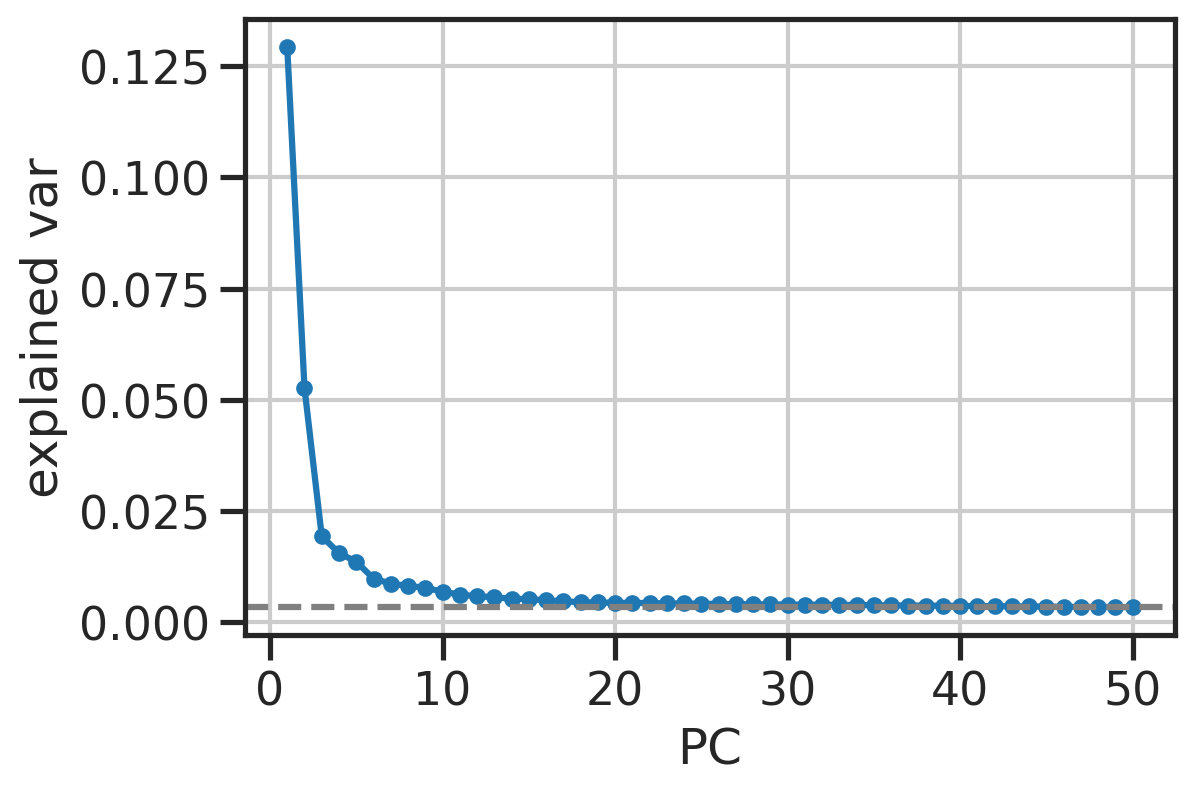

In [11]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(len(pca.explained_variance_ratio_))+1, pca.explained_variance_ratio_, '-o', markersize=5)
ax.axhline(1/lognorm.shape[1], linestyle='--', color='gray')
ax.set_xlabel('PC')
ax.set_ylabel('explained var')

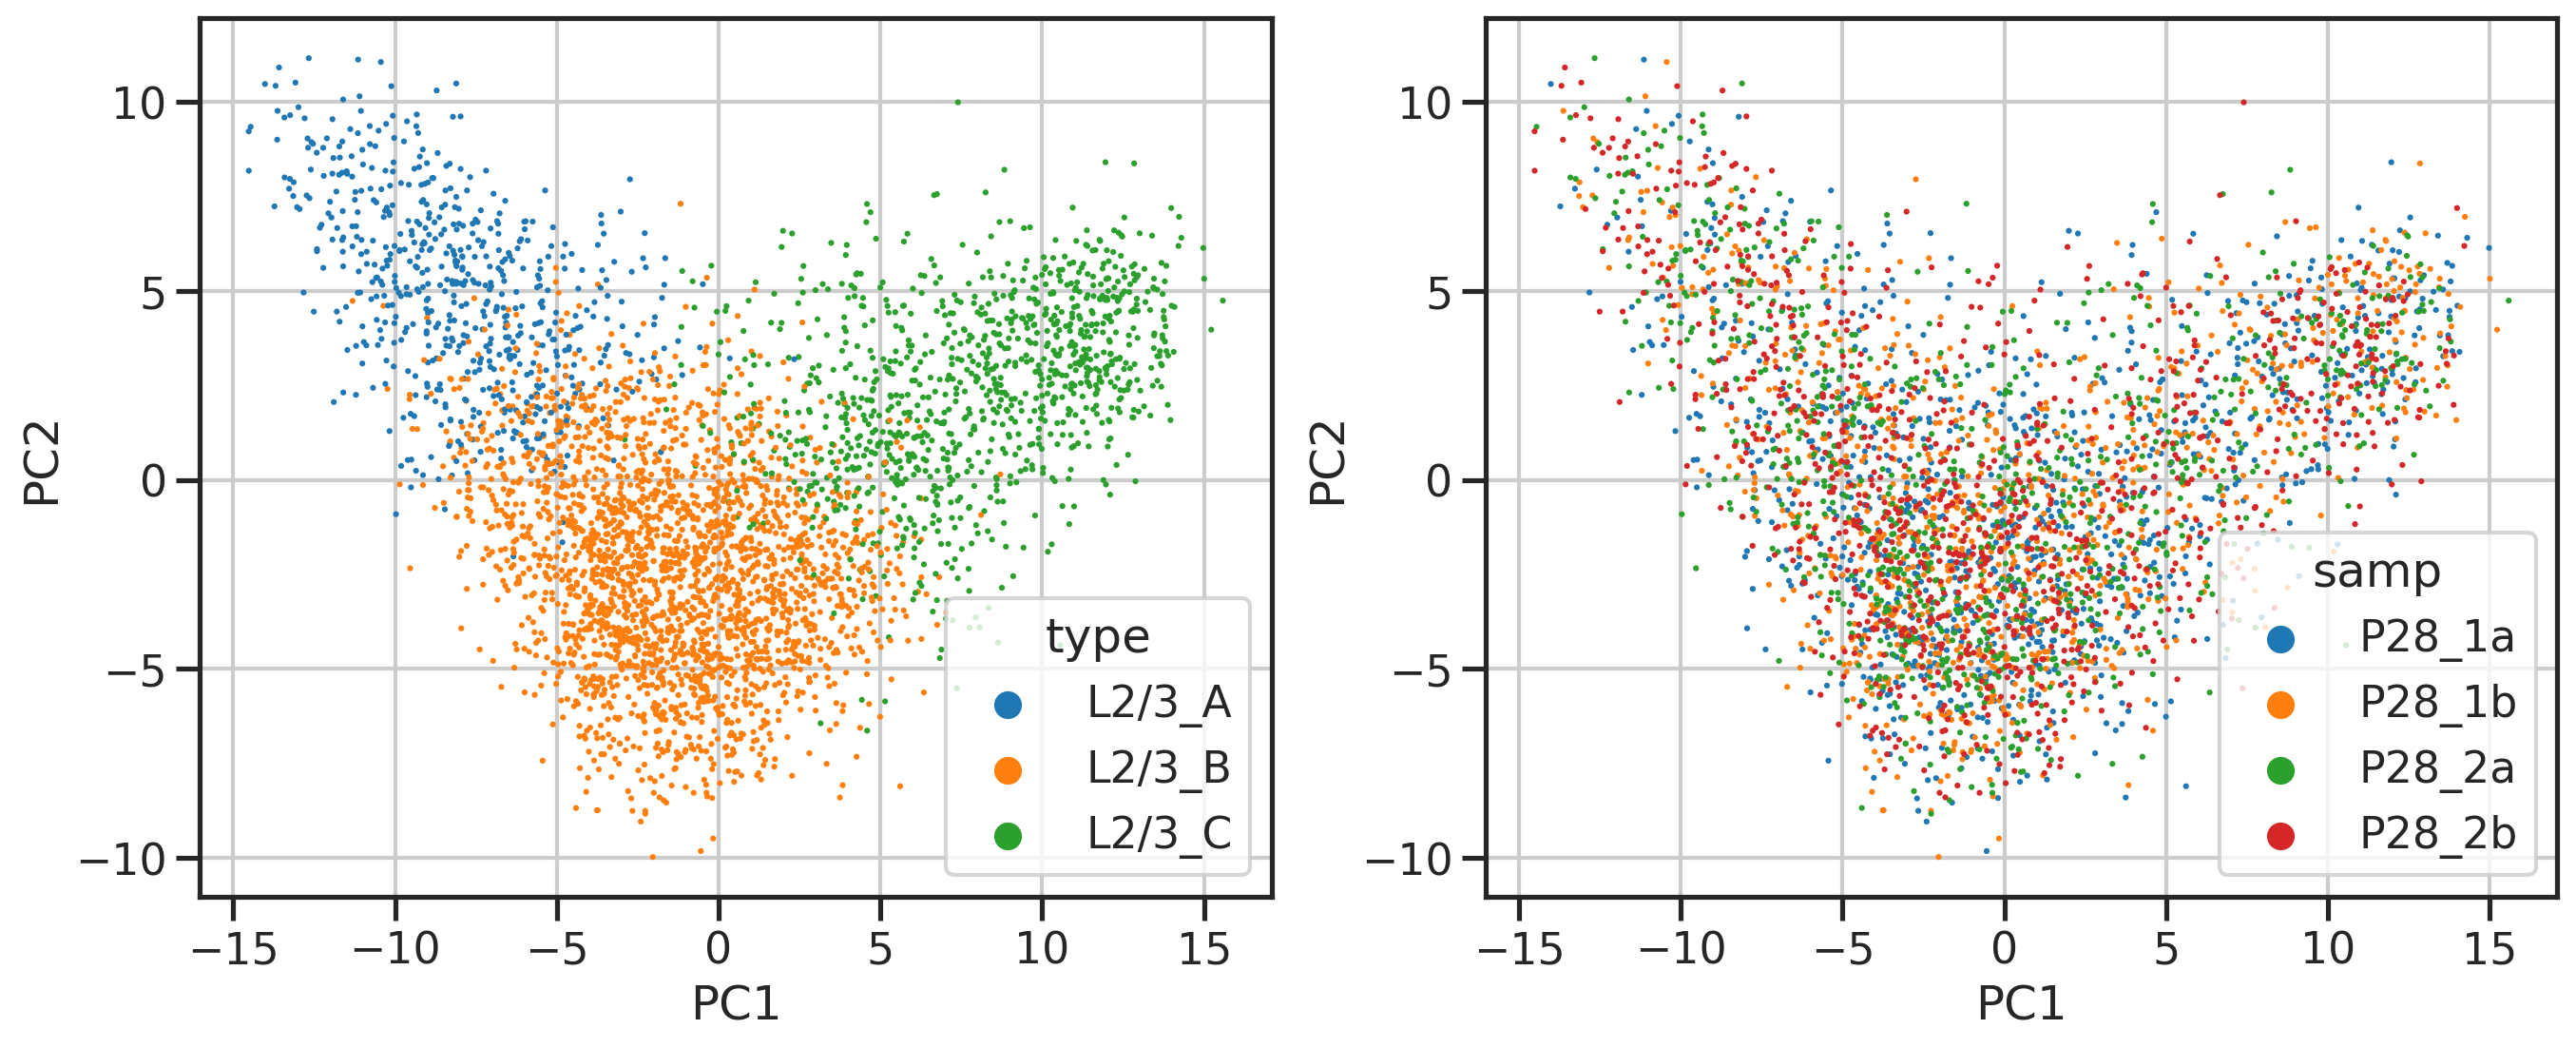

In [12]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

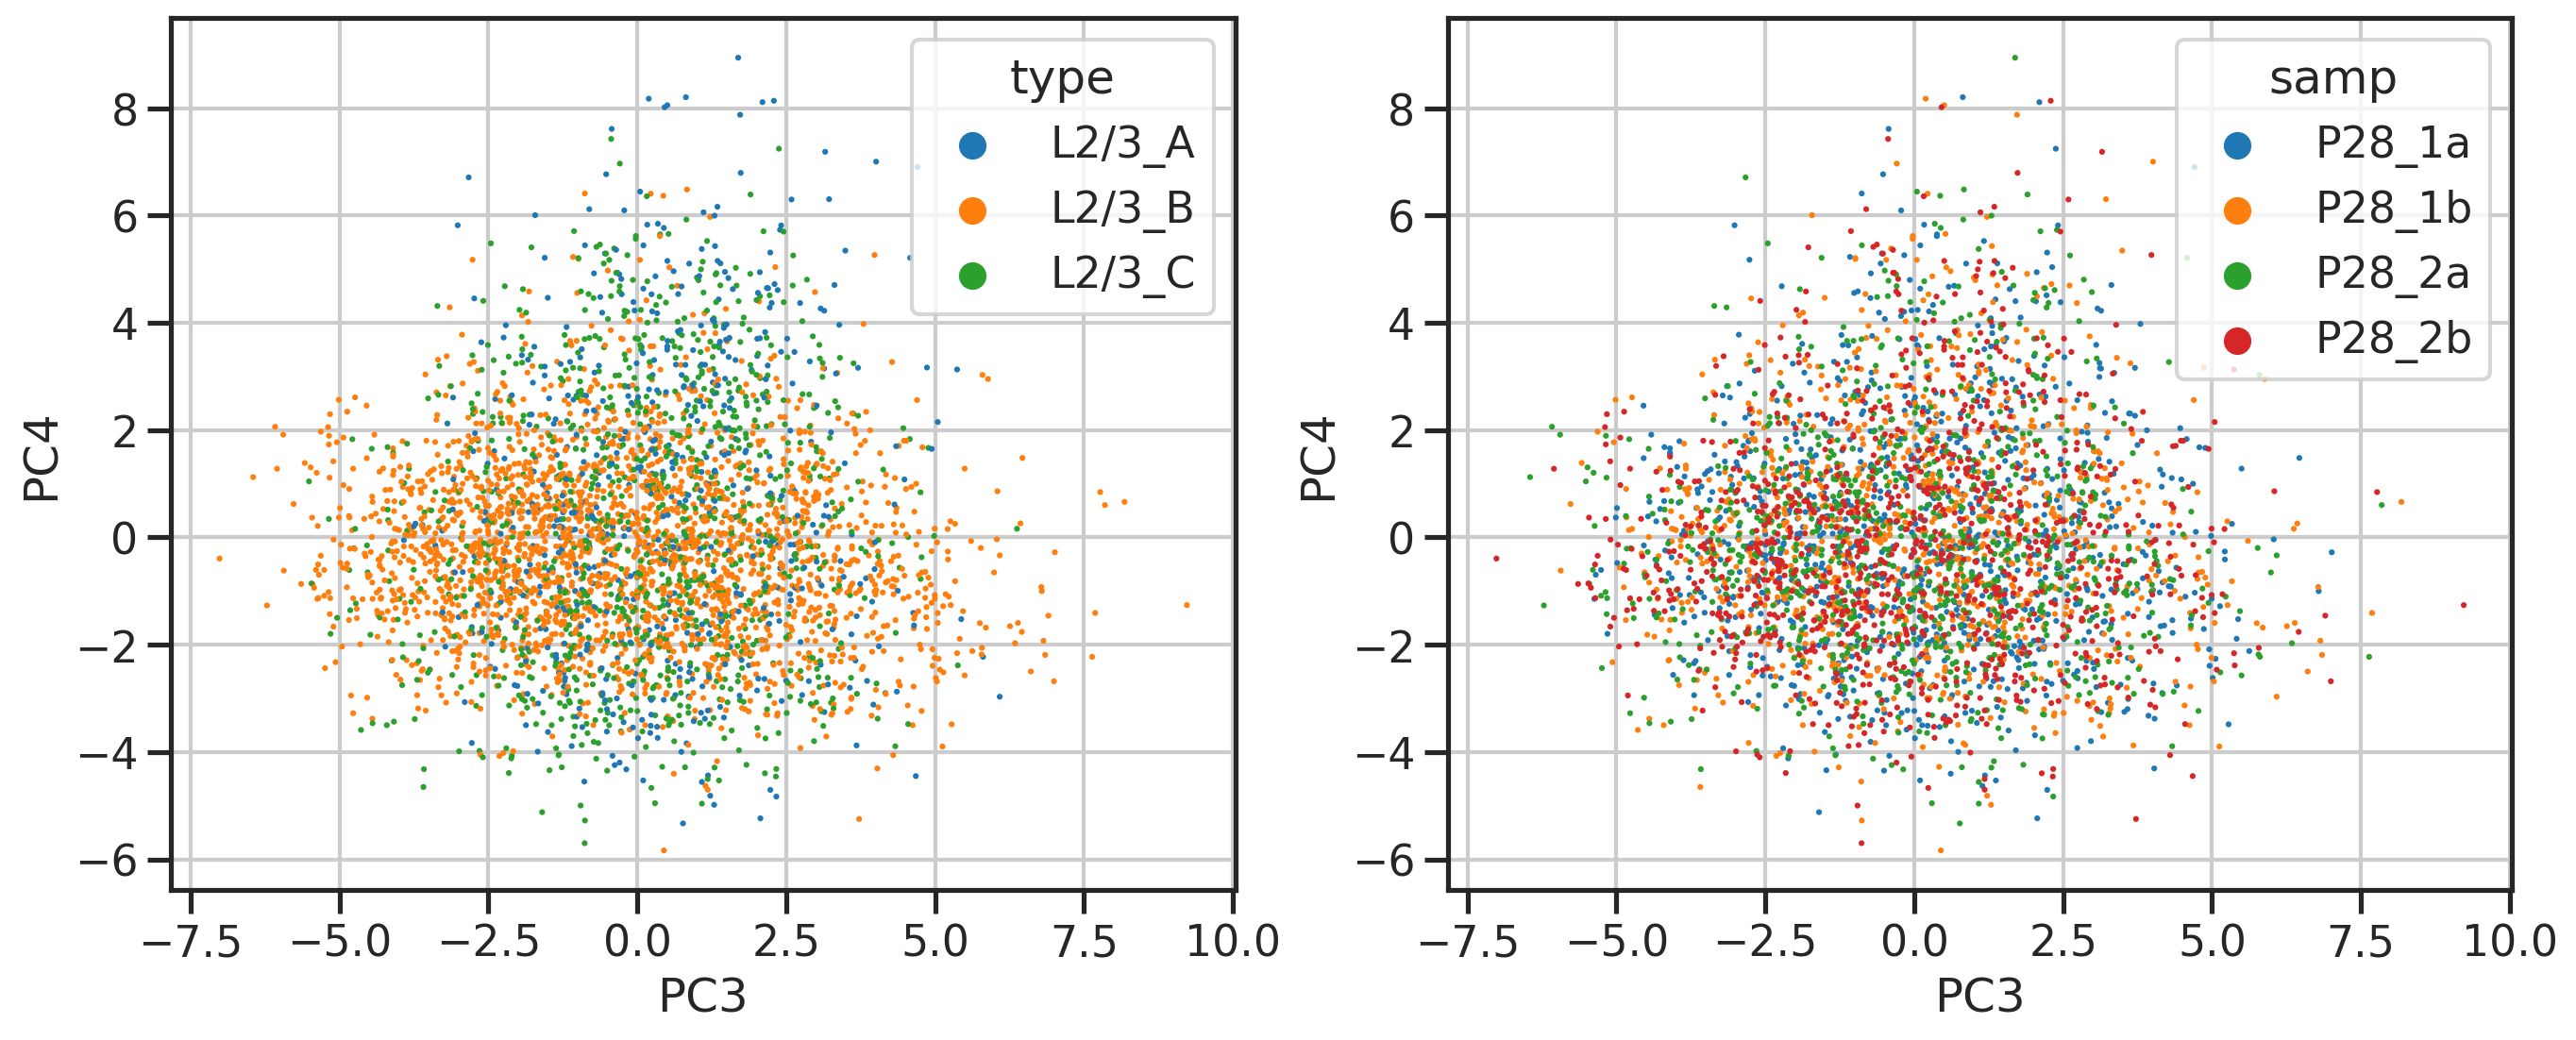

In [13]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

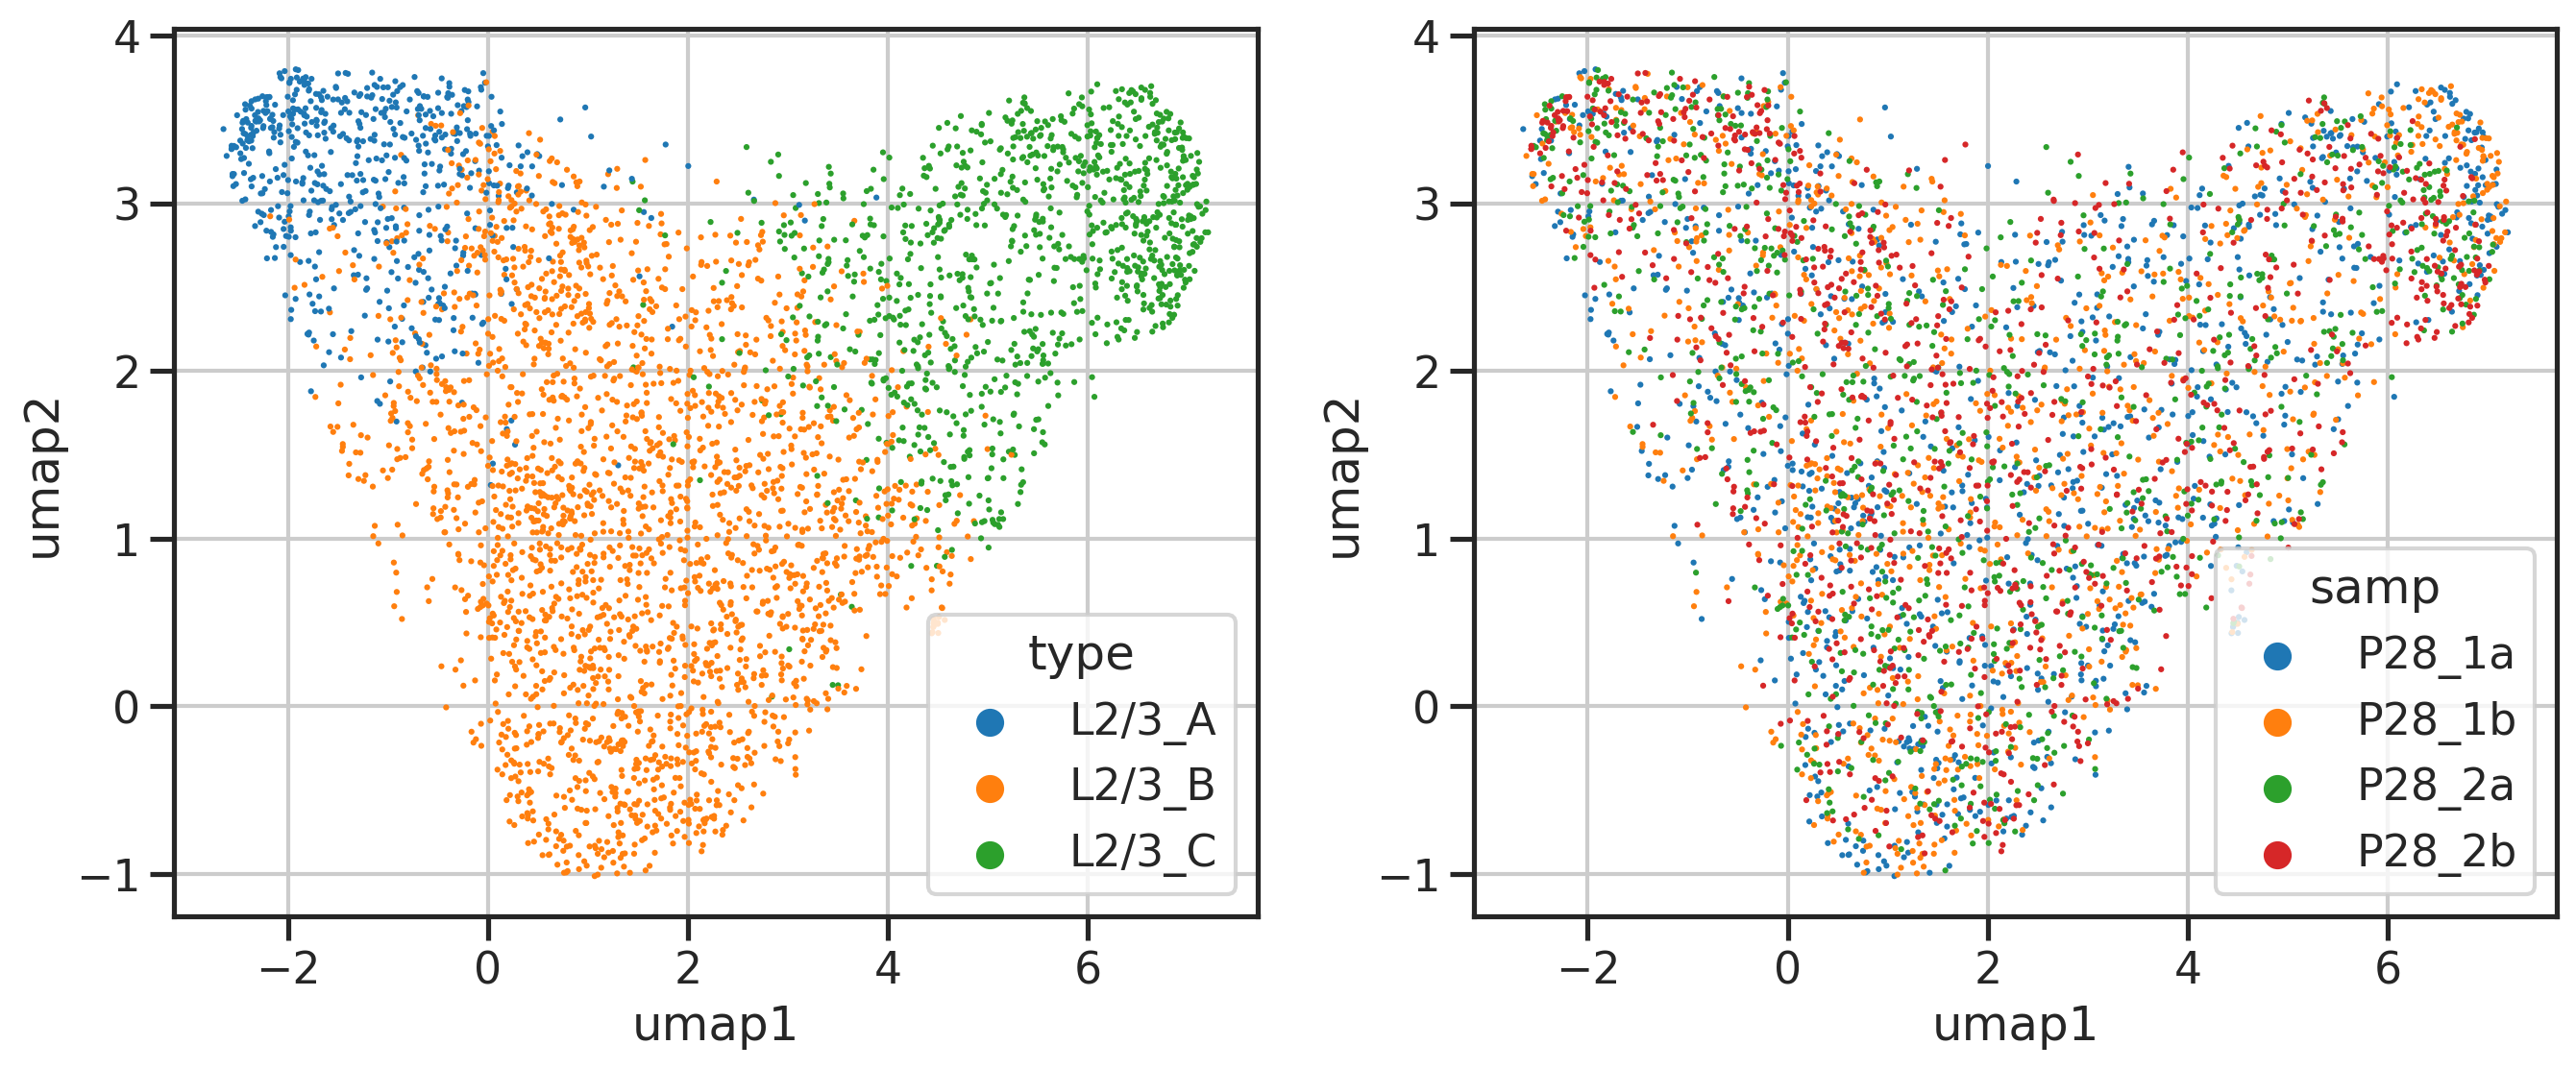

In [14]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

# heatmap

In [15]:
rowidx = basicu.order_by_hc(zlognorm)
# colidx = basicu.order_by_hc(zlognorm.T)

In [16]:
my_colors = ('C0', 'C1', 'C2')
cmap_d1 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

my_colors = ('C0', 'C1', 'C2', 'C3')
cmap_d2 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

In [17]:
ncell, ngene = zlognorm.shape

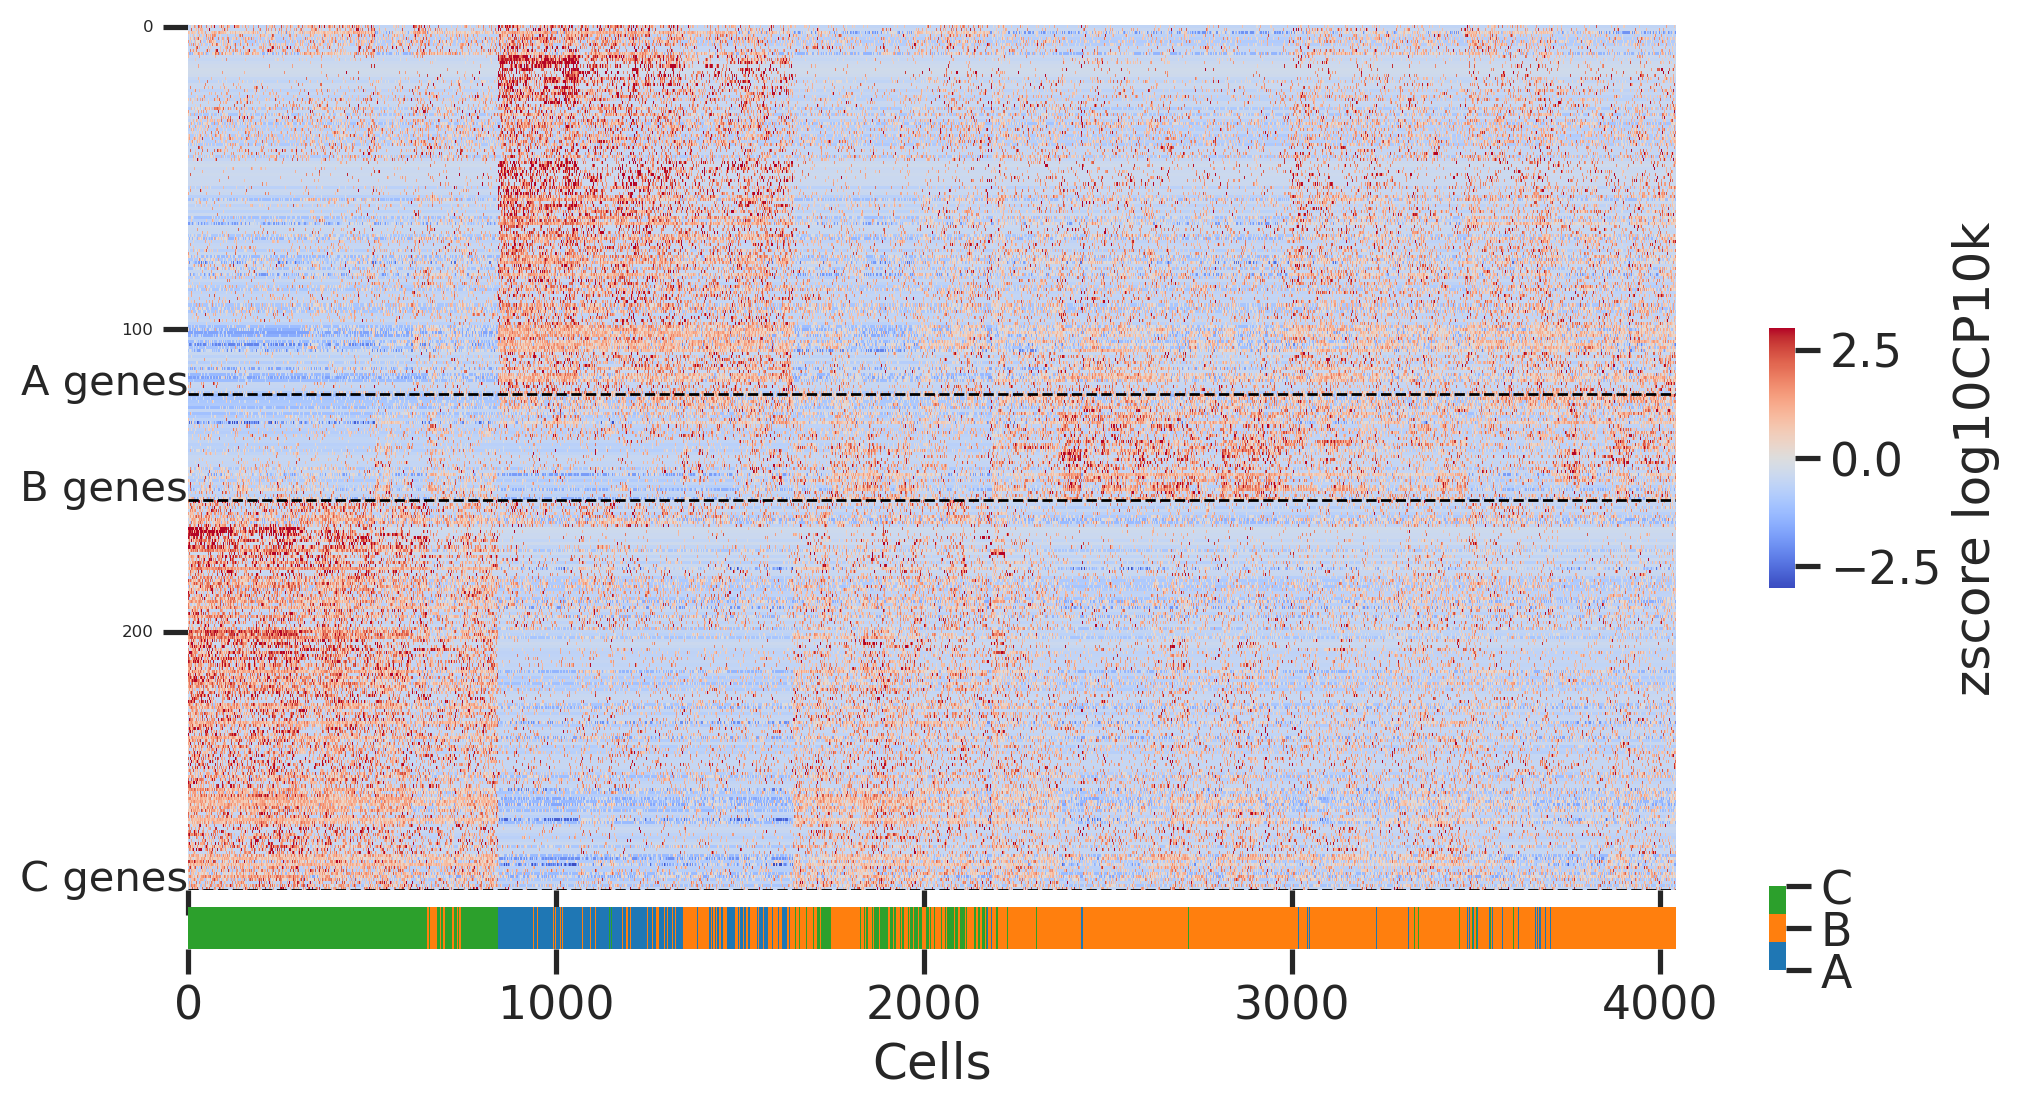

In [18]:
fig, axdict = plt.subplot_mosaic("A\n"*15+"B", figsize=(12,6), sharex=True)
ax = axdict['A']
sns.heatmap(zlognorm[rowidx].T,
            xticklabels=1000,
            yticklabels=100,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            ax=ax,
           )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=6)

ax.hlines(np.cumsum(gene_type_counts), 0, ncell, linewidth=1, linestyle='--', color='k')
for y, lbl in zip(np.cumsum(gene_type_counts), ['A genes', 'B genes', 'C genes']):
    ax.text(0, y, lbl, fontsize=15, ha='right')

ax = axdict['B']
sns.heatmap(pd.factorize(types[rowidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=1000,
            yticklabels=False,
            cmap=cmap_d1,
            cbar_kws=dict(ticks=[0,1,2], shrink=2, aspect=5),
            ax=ax, 
           )
ax.set_xlabel('Cells')
fig.axes[-1].set_yticklabels(['A','B','C'])

fig.subplots_adjust(hspace=0.4)
plt.show()

# give each cell a pseudo-time index

In [19]:
adata.obsm['X_pca'] = pcs

In [20]:
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca')
sc.tl.diffmap(adata)
# adata.uns['iroot'] = np.flatnonzero(adata.obs['Type']=='L2/3_A')[0]
adata.uns['iroot'] = np.argmin(pcs[:,0])
sc.tl.dpt(adata)
adata

AnnData object with n_obs × n_vars = 4044 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass', 'dpt_pseudotime'
    uns: 'neighbors', 'diffmap_evals', 'iroot'
    obsm: 'X_pca', 'X_diffmap'
    obsp: 'distances', 'connectivities'

In [21]:
adata.obsm['X_diffmap'].shape

(4044, 15)

In [22]:
res['ptime'] = adata.obs['dpt_pseudotime'].values

# check pseudotime (and diff map)

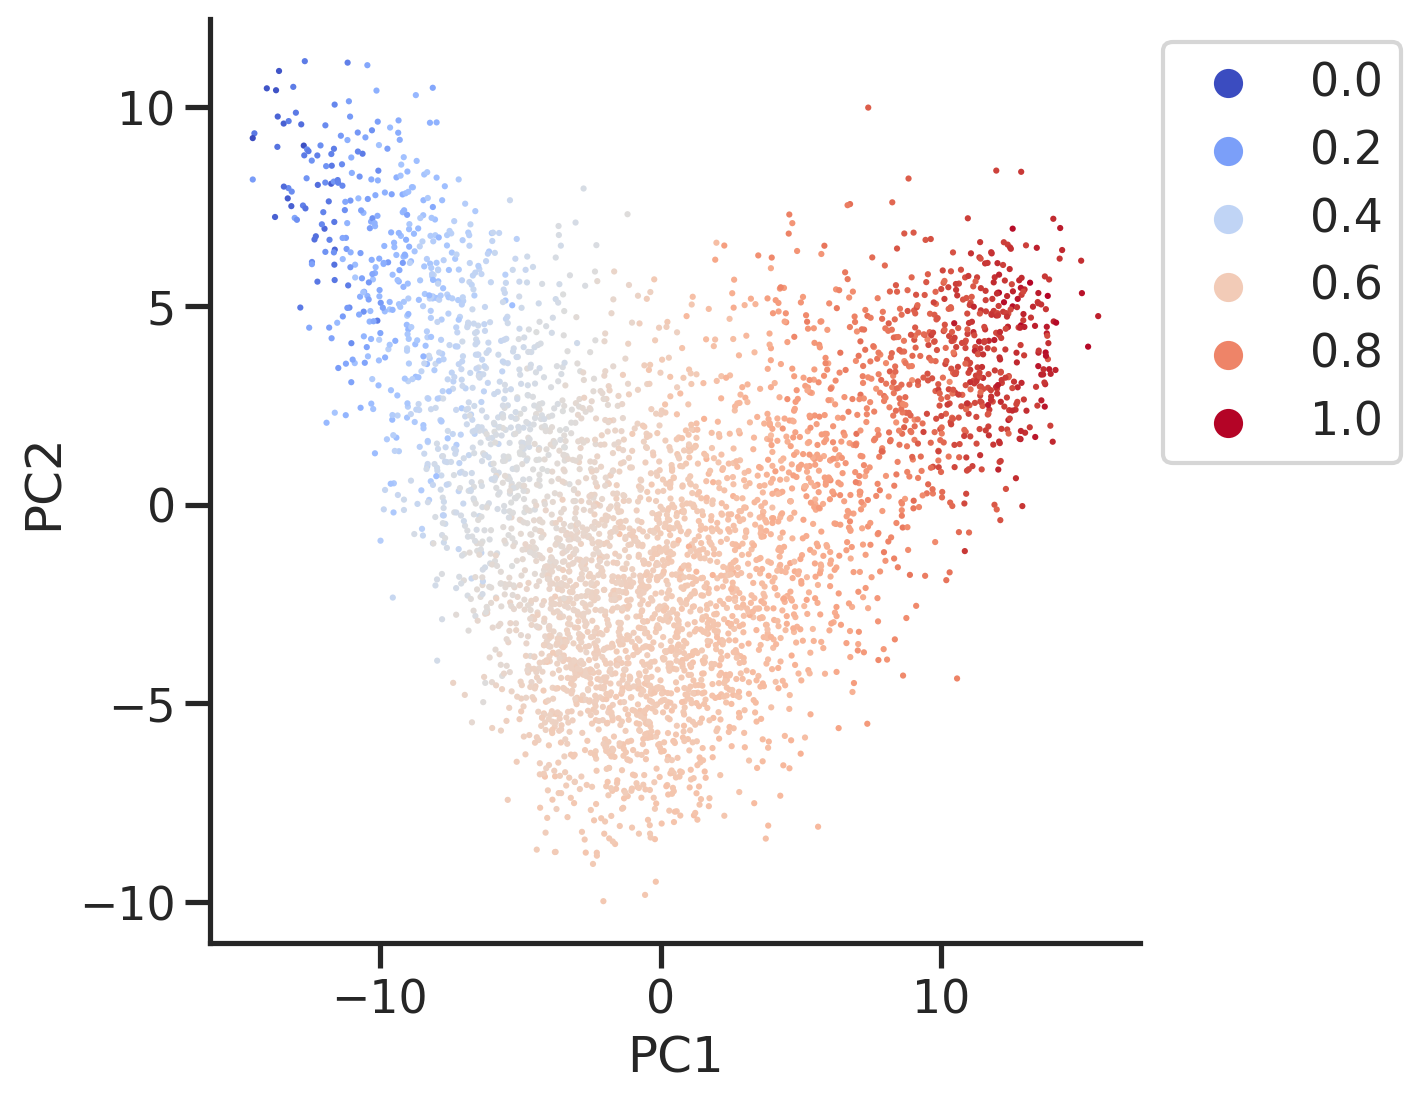

In [23]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=res, 
                x='PC1',
                y='PC2',
                hue='ptime',
                # hue_order=np.sort(adata.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
                palette='coolwarm',
               )
# ax.set_xlabel(f'PC1 ({pca_v[0]*100:.1f}% var)')
# ax.set_ylabel(f'PC2 ({pca_v[1]*100:.1f}% var)')

ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
ax.grid(False)
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
plt.show()

03-27 13:08:52 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


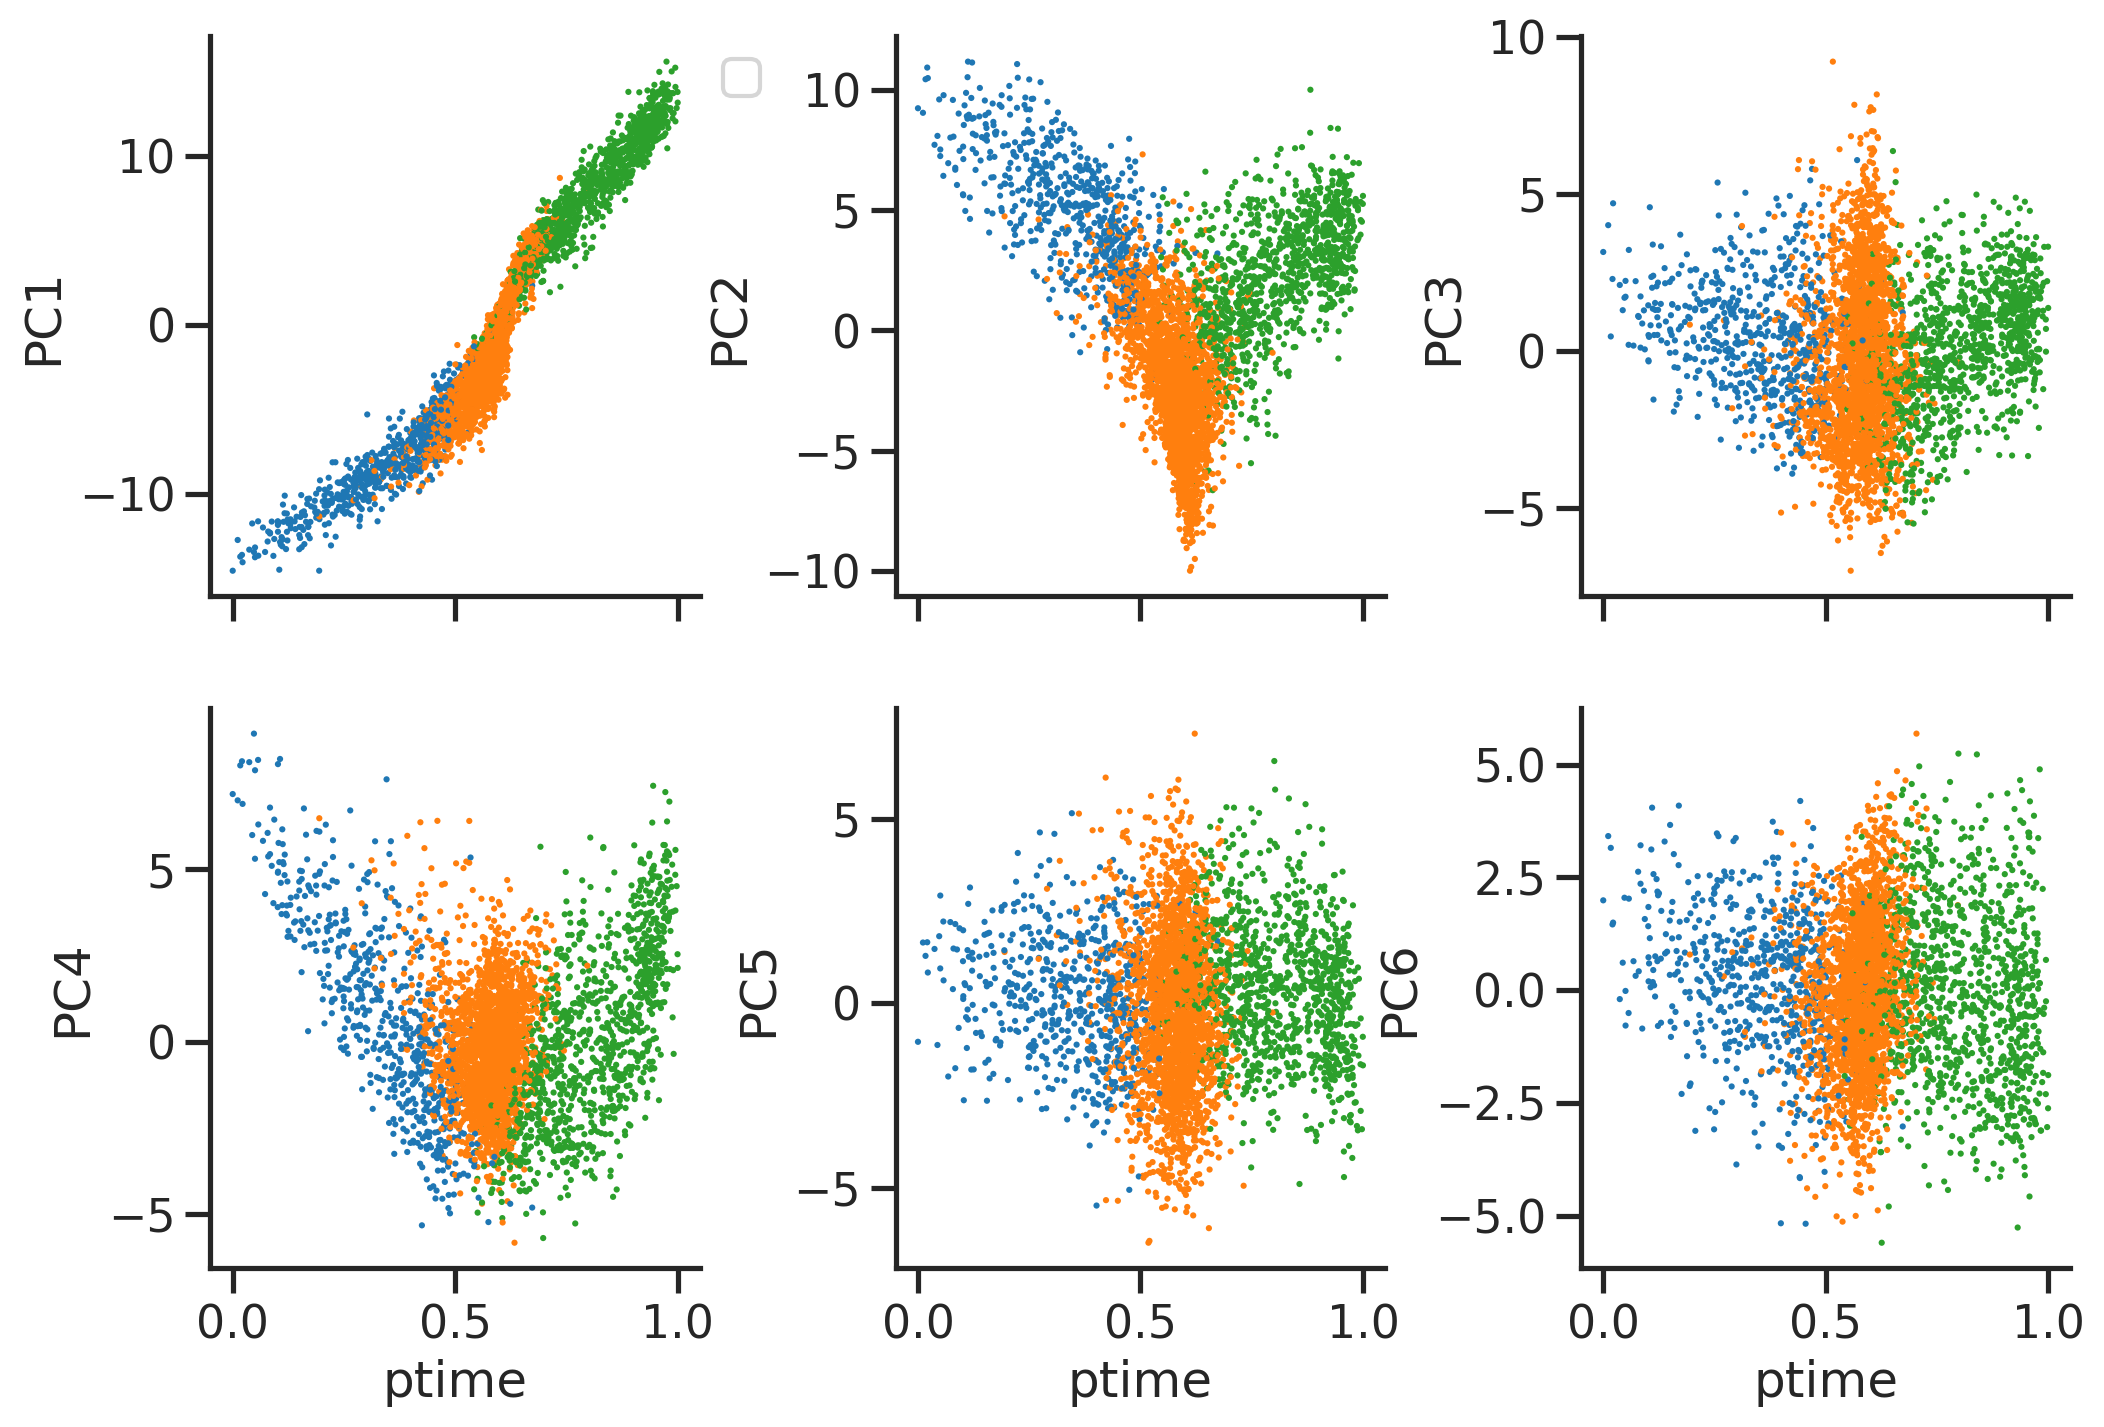

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(4*3,4*2), sharex=True)
for i, ax in enumerate(axs.flat):
    sns.scatterplot(data=res, 
                    x='ptime',
                    y=f'PC{i+1}',
                    hue='type',
                    edgecolor='none',
                    s=5,
                    ax=ax,
                    legend=False,
                   )
    ax.grid(False)
    sns.despine(ax=ax)
axs.flat[0].legend(bbox_to_anchor=(1,1), loc='upper left')
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
fig.subplots_adjust(wspace=0.4)
plt.show()

In [25]:
cellidx = np.argsort(res['ptime'].values)

03-27 13:08:55 - maxp pruned
03-27 13:08:55 - cmap pruned
03-27 13:08:55 - kern dropped
03-27 13:08:55 - post pruned
03-27 13:08:55 - FFTM dropped
03-27 13:08:55 - GPOS pruned
03-27 13:08:55 - GSUB pruned
03-27 13:08:55 - name pruned
03-27 13:08:55 - glyf pruned
03-27 13:08:55 - Added gid0 to subset
03-27 13:08:55 - Added first four glyphs to subset
03-27 13:08:55 - Closing glyph list over 'GSUB': 29 glyphs before
03-27 13:08:55 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'N', 'P', 'R', 'c', 'e', 'eight', 'five', 'four', 'g', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'space', 'three', 'two', 'z', 'zero']
03-27 13:08:55 - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 27, 36, 37, 38, 49, 51, 53, 70, 72, 74, 78, 79, 81, 82, 85, 86, 93, 3228]
03-27 13:08:55 - Closed glyph list over 'GSUB': 29 glyphs after
03-27 13:08:55 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'N', 'P', 'R', 'c', 'e', 'eight', 'five', 'four', 'g', 'k', 'l', 'minus'

saved the figure to: /scr/qlyu/projects/v1/figures/heatmap_P28NR_v1_2023-03-27.pdf


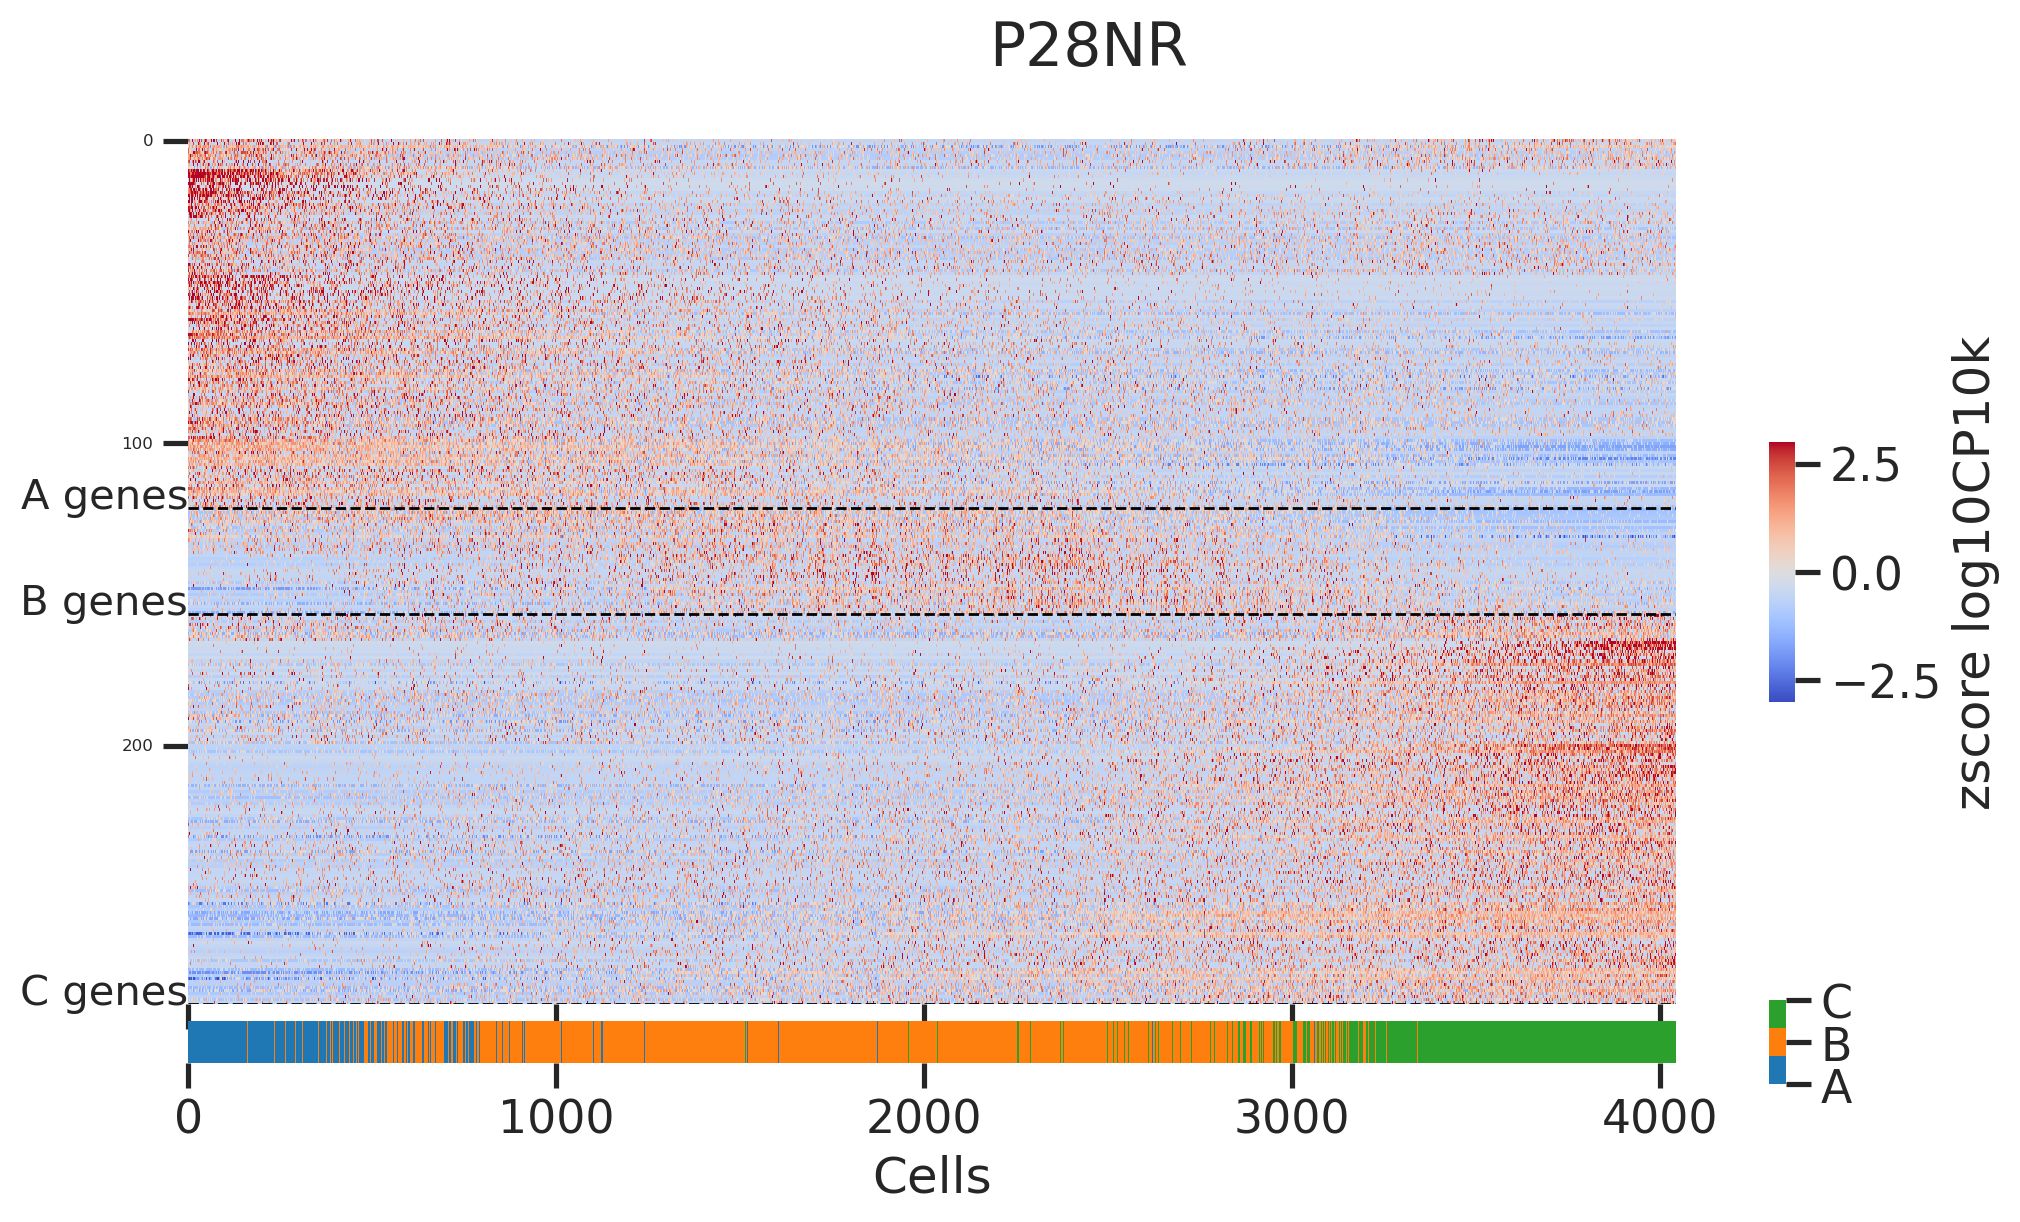

In [26]:
fig, axdict = plt.subplot_mosaic("A\n"*15+"B", figsize=(12,6), sharex=True)
ax = axdict['A']
sns.heatmap(zlognorm[cellidx].T,
            xticklabels=1000,
            yticklabels=100,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            rasterized=True,
            ax=ax,
           )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=6)

ax.hlines(np.cumsum(gene_type_counts), 0, ncell, linewidth=1, linestyle='--', color='k')
for y, lbl in zip(np.cumsum(gene_type_counts), ['A genes', 'B genes', 'C genes']):
    ax.text(0, y, lbl, fontsize=15, ha='right')

ax = axdict['B']
sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=1000,
            yticklabels=False,
            cmap=cmap_d1,
            cbar_kws=dict(ticks=[0,1,2], shrink=2, aspect=5),
            rasterized=True,
            ax=ax, 
           )
ax.set_xlabel('Cells')
fig.axes[-1].set_yticklabels(['A','B','C'])
fig.suptitle(sample)
fig.subplots_adjust(hspace=0.4)
powerplots.savefig_autodate(fig, os.path.join(outdir_fig, f'heatmap_{sample}_v1.pdf'))
plt.show()

# Give each gene a pseudo time too
- assign each gene a ptime as the weighted average of cell ptime

In [27]:
weights = ((lognorm+1e-10)/(lognorm.sum(axis=0)+1e-10))
gptime  = res['ptime'].values.dot(weights)
geneidx = np.argsort(gptime)

03-27 13:08:59 - maxp pruned
03-27 13:08:59 - cmap pruned
03-27 13:08:59 - kern dropped
03-27 13:08:59 - post pruned
03-27 13:08:59 - FFTM dropped
03-27 13:08:59 - GPOS pruned
03-27 13:08:59 - GSUB pruned
03-27 13:08:59 - name pruned
03-27 13:08:59 - glyf pruned
03-27 13:08:59 - Added gid0 to subset
03-27 13:08:59 - Added first four glyphs to subset
03-27 13:08:59 - Closing glyph list over 'GSUB': 30 glyphs before
03-27 13:08:59 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'G', 'N', 'P', 'R', 'c', 'e', 'eight', 'five', 'four', 'g', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'space', 'three', 'two', 'z', 'zero']
03-27 13:08:59 - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 27, 36, 37, 38, 42, 49, 51, 53, 70, 72, 74, 78, 79, 81, 82, 85, 86, 93, 3228]
03-27 13:08:59 - Closed glyph list over 'GSUB': 30 glyphs after
03-27 13:08:59 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'G', 'N', 'P', 'R', 'c', 'e', 'eight', 'five', 'four', 'g', 'k'

saved the figure to: /scr/qlyu/projects/v1/figures/heatmap_P28NR_v2_2023-03-27.pdf


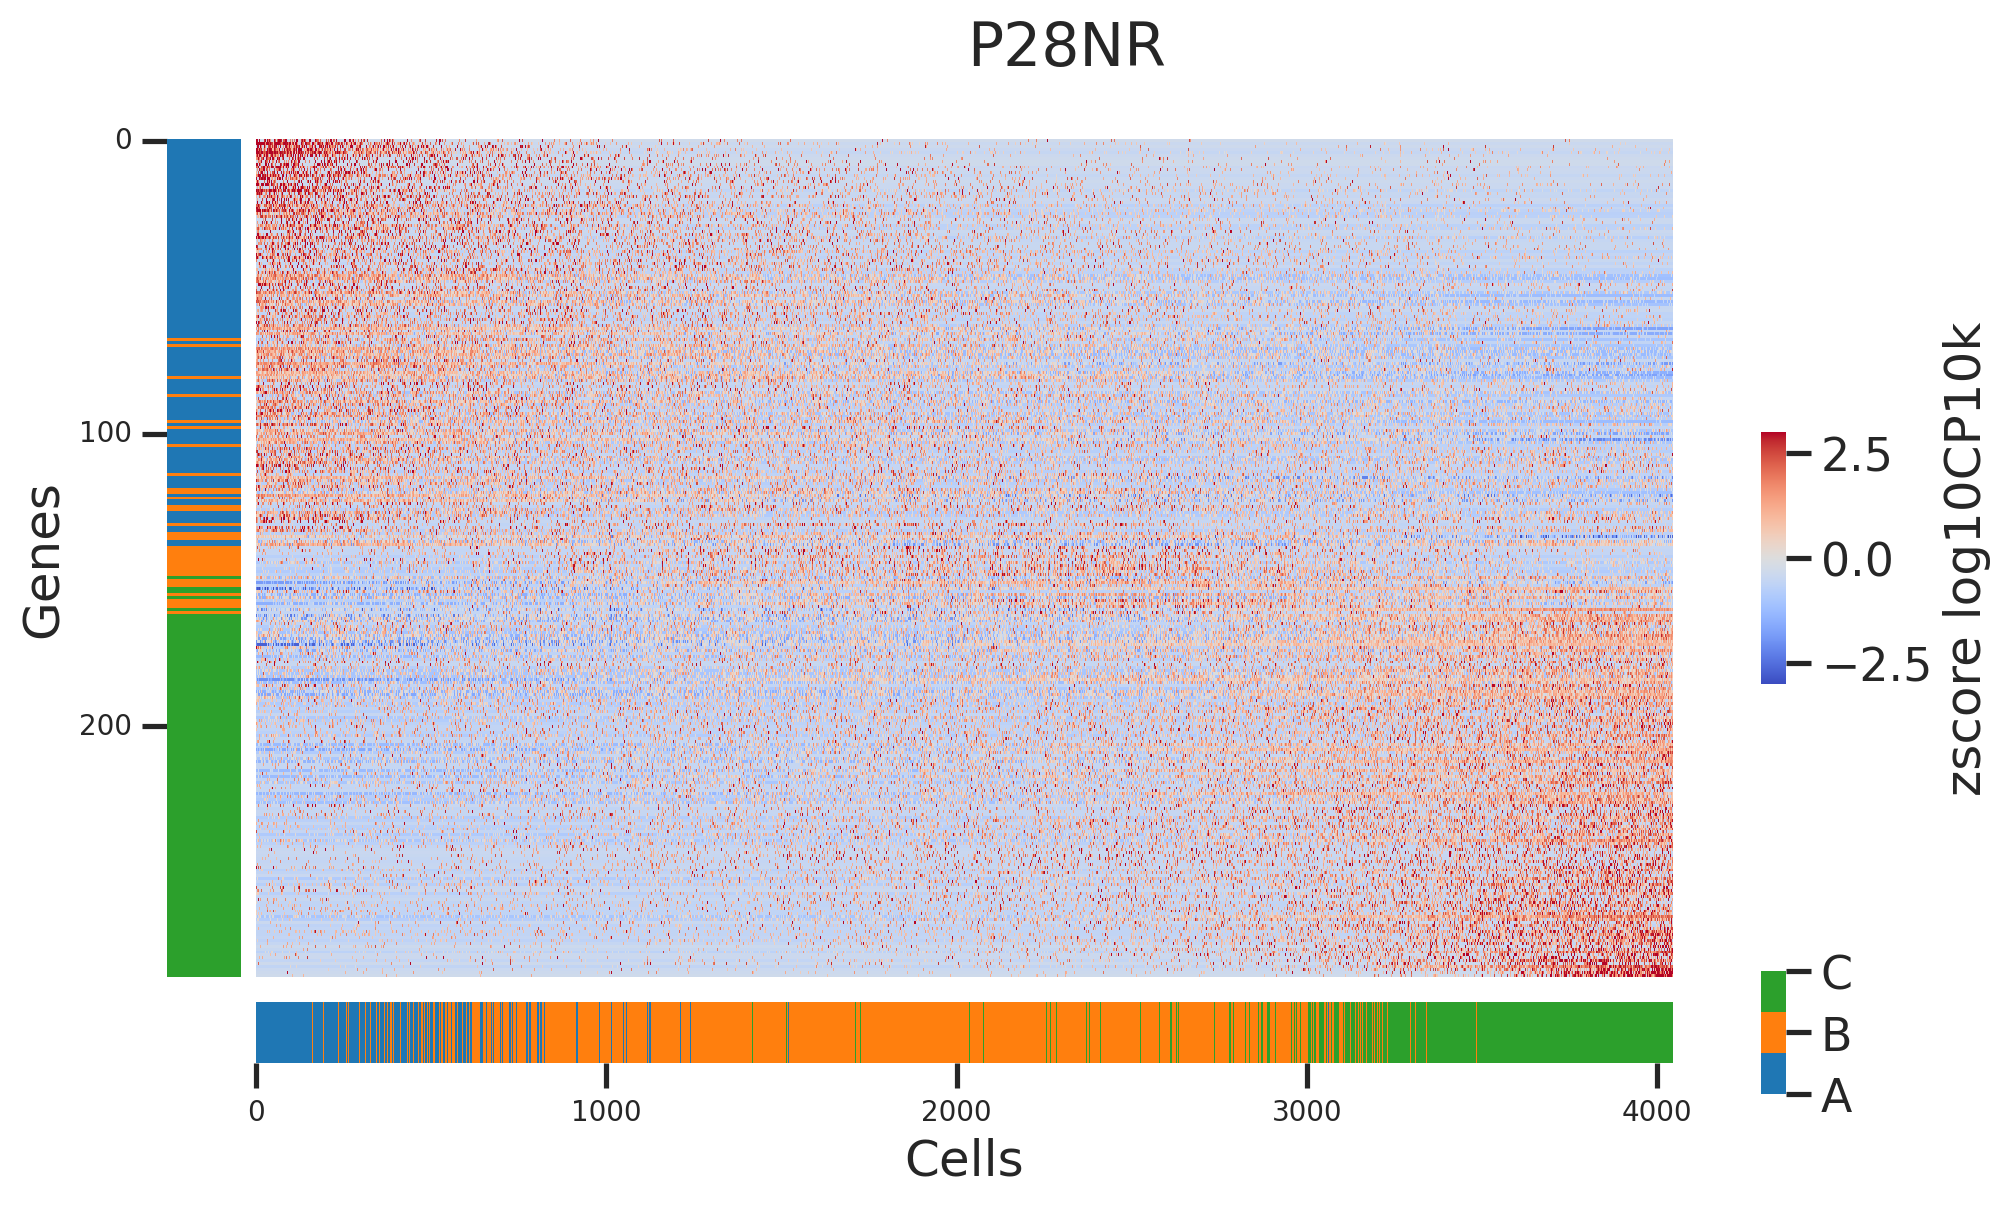

In [28]:
mosaic = ("B"+"A"*20+"\n")*10 + "."+"C"*20
# print(mosaic)

fig, axdict = plt.subplot_mosaic(mosaic, figsize=(12,6))
ax = axdict['A']
sns.heatmap(zlognorm[cellidx][:,geneidx].T,
            xticklabels=False,
            yticklabels=False,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            rasterized=True,
            ax=ax,
           )

ax = axdict['C']
sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=1000,
            yticklabels=False,
            cmap=cmap_d1,
            cbar_kws=dict(ticks=[0,1,2], shrink=2, aspect=5),
            rasterized=True,
            ax=ax, 
           )
ax.set_xlabel('Cells')
fig.axes[-1].set_yticklabels(['A','B','C'])
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

ax = axdict['B']
sns.heatmap(pd.factorize(genes_grp[geneidx], sort=True)[0].reshape(-1,1), 
            xticklabels=False,
            yticklabels=100,
            cmap=cmap_d1,
            cbar=False,
            rasterized=True,
            ax=ax, 
           )
ax.set_ylabel('Genes')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

fig.subplots_adjust(hspace=0.4)
fig.suptitle(sample)
powerplots.savefig_autodate(fig, os.path.join(outdir_fig, f'heatmap_{sample}_v2.pdf'))
plt.show()

# Use P28 ordering

In [29]:
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
geneidx2 = np.argsort(gpt)

03-27 13:09:03 - maxp pruned
03-27 13:09:03 - cmap pruned
03-27 13:09:03 - kern dropped
03-27 13:09:03 - post pruned
03-27 13:09:03 - FFTM dropped
03-27 13:09:03 - GPOS pruned
03-27 13:09:03 - GSUB pruned
03-27 13:09:03 - name pruned
03-27 13:09:03 - glyf pruned
03-27 13:09:03 - Added gid0 to subset
03-27 13:09:03 - Added first four glyphs to subset
03-27 13:09:03 - Closing glyph list over 'GSUB': 30 glyphs before
03-27 13:09:03 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'G', 'N', 'P', 'R', 'c', 'e', 'eight', 'five', 'four', 'g', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'space', 'three', 'two', 'z', 'zero']
03-27 13:09:03 - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 27, 36, 37, 38, 42, 49, 51, 53, 70, 72, 74, 78, 79, 81, 82, 85, 86, 93, 3228]
03-27 13:09:03 - Closed glyph list over 'GSUB': 30 glyphs after
03-27 13:09:03 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'G', 'N', 'P', 'R', 'c', 'e', 'eight', 'five', 'four', 'g', 'k'

saved the figure to: /scr/qlyu/projects/v1/figures/heatmap_P28NR_v3_2023-03-27.pdf


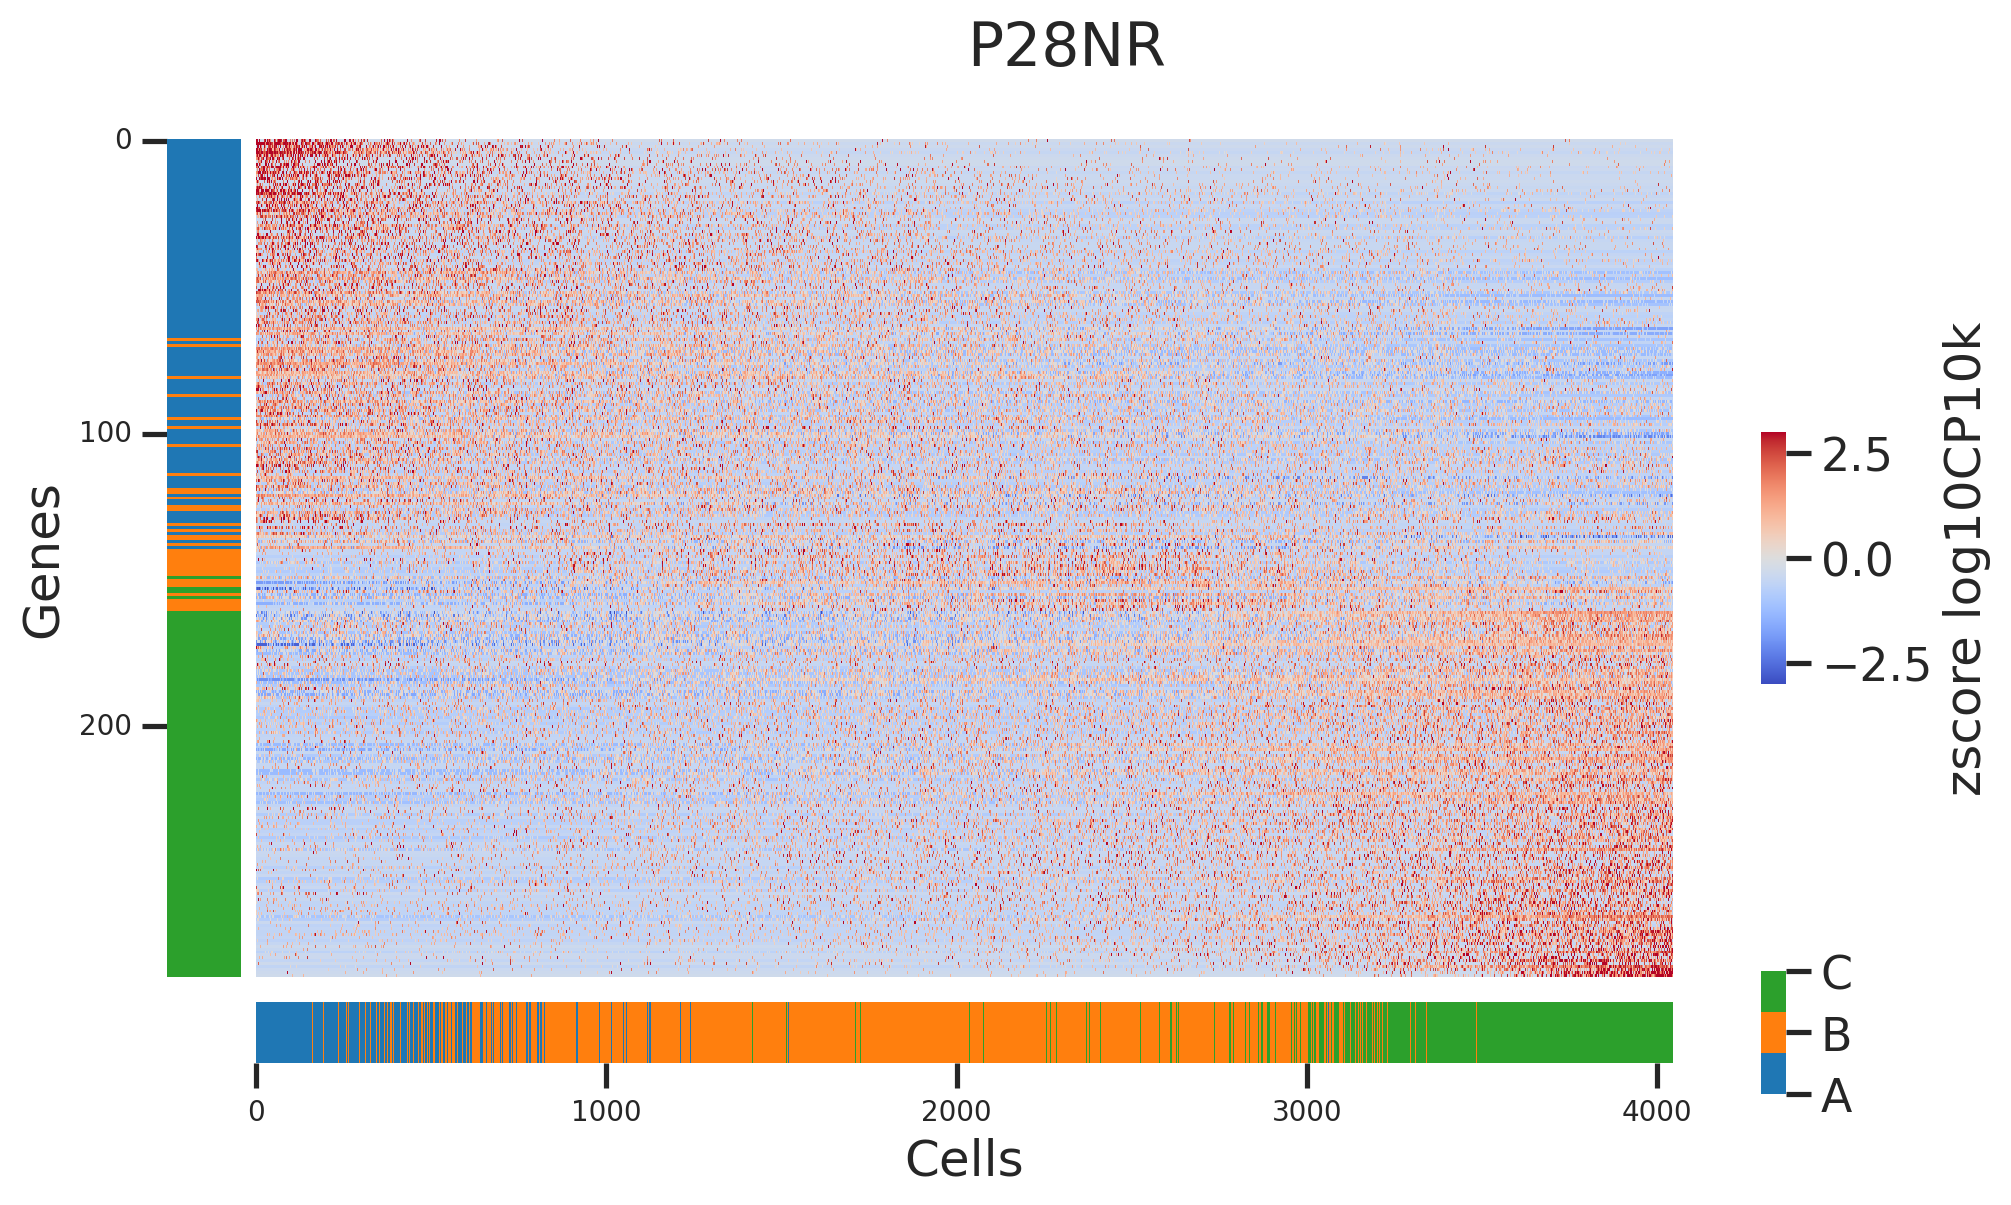

In [30]:

mosaic = ("B"+"A"*20+"\n")*10 + "."+"C"*20
# print(mosaic)

fig, axdict = plt.subplot_mosaic(mosaic, figsize=(12,6))
ax = axdict['A']
sns.heatmap(zlognorm[cellidx][:,geneidx2].T,
            xticklabels=False,
            yticklabels=False,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            rasterized=True,
            ax=ax,
           )

ax = axdict['C']
sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=1000,
            yticklabels=False,
            cmap=cmap_d1,
            cbar_kws=dict(ticks=[0,1,2], shrink=2, aspect=5),
            rasterized=True,
            ax=ax, 
           )
ax.set_xlabel('Cells')
fig.axes[-1].set_yticklabels(['A','B','C'])
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

ax = axdict['B']
sns.heatmap(pd.factorize(genes_grp[geneidx2], sort=True)[0].reshape(-1,1), 
            xticklabels=False,
            yticklabels=100,
            cmap=cmap_d1,
            cbar=False,
            rasterized=True,
            ax=ax, 
           )
ax.set_ylabel('Genes')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

fig.subplots_adjust(hspace=0.4)
fig.suptitle(sample)
powerplots.savefig_autodate(fig, os.path.join(outdir_fig, f'heatmap_{sample}_v3.pdf'))
plt.show()